In [1]:
from __future__  import print_function, division
#Author: Avikal Somvanshi
import pylab as pl
import pandas as pd
import numpy as np
import os
from scipy import stats
%pylab inline

if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2016")

import os
import json


Populating the interactive namespace from numpy and matplotlib


IDEA:
Women bike for longer duration than men.

NULL HYPOTHESIS:
The average trip duration of women biking is the same or lower than the average trip duration of a woman biking.

Ho : Fduration.mean() <= Mduration.mean() 

Ha : Fduration.mean() > Mduration.mean() 

I will use a significance level  alpha=0.05

In [2]:
#Using the code from sample sheet
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
                os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
datestring = '201501'
getCitiBikeCSV(datestring)

file in place, you can continue


In [4]:
df=pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df['date'] = pd.to_datetime(df['starttime'])
df.head() #showing the data tables for the unreducted datasets 

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,2015-01-01 00:05:00


In [5]:
#reducted the datasets 
duration_data = df[[0, 14]]
duration_data.head() #showing the data tables for the reducted datasets 

,tripduration,gender
0,1346,2
1,363,1
2,346,1
3,182,1
4,969,1


In [6]:
# grouping the data as per the gender
grouped = duration_data.groupby(['gender'])
grouped

In [7]:
#Counting the sample sizes
group_size = pd.DataFrame(grouped['gender'].apply(np.size))
group_size

,gender
gender,
0,5695
1,227764
2,52093


In [8]:
#Extracting data for male and female in independent dataframes and rejecting the gender '0' 
male = pd.DataFrame(grouped.get_group(1))
male = male[[0]] / 60 # converting the duration to minutes
male.columns = ['male_TD']
m_size = np.size(male['male_TD'])
m_mean = np.mean(male['male_TD'])
m_std = np.std(male['male_TD'])
print ('Male Sample Size: ', m_size)
print ('Male Sample Mean: ', m_mean)
print ('Male Sample Standard Diviation: ', m_std)
male.describe()

Male Sample Size:  227764
Male Sample Mean:  10.3760066706
Male Sample Standard Diviation:  14.0954617879


,male_TD
count,227764.000000
mean,10.376007
std,14.095493
min,1.000000
25%,5.416667
50%,8.116667
75%,12.316667
max,717.050000


In [9]:
female = pd.DataFrame(grouped.get_group(2))
female = female[[0]] / 60
female.columns = ['female_TD']
f_size = np.size(female['female_TD'])
f_mean = np.mean(female['female_TD'])
f_std = np.std(female['female_TD'])
print ('Female Sample Size: ', f_size)
print ('Female Sample Mean: ', f_mean)
print ('Female Sample Standard Diviation: ', f_std)
female.describe()

Female Sample Size:  52093
Female Sample Mean:  11.5396563198
Female Sample Standard Diviation:  14.3085051883


,female_TD
count,52093.000000
mean,11.539656
std,14.308643
min,1.000000
25%,6.100000
50%,9.200000
75%,13.883333
max,699.350000


In [10]:
nemale = pd.DataFrame(grouped.get_group(0))
nemale = nemale[[0]] / 60
nemale.columns = ['TD']

nemale.describe()

,TD
count,5695.000000
mean,26.277474
std,35.091069
min,1.000000
25%,11.241667
50%,18.916667
75%,28.483333
max,677.700000


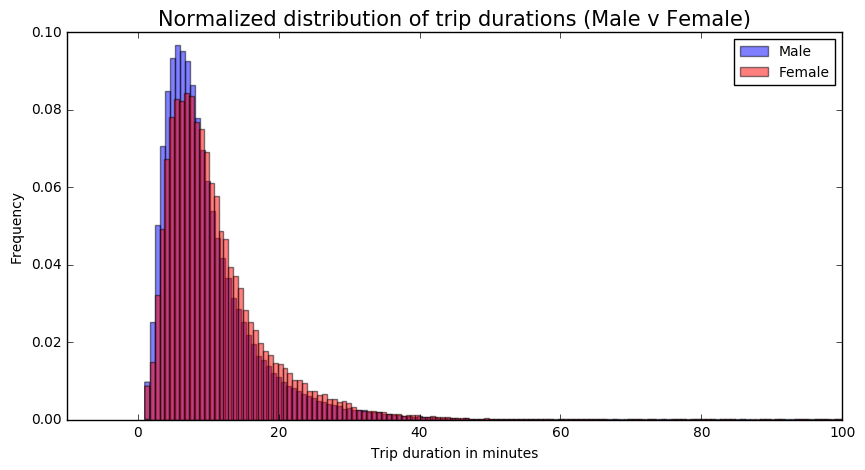

In [11]:
#Ploting the distribution 
pl.figure(figsize=(10, 5))
pl.xlim(-10, 100) #largest value for trip duration is about 800 minutes, but to maintain readability of the histogram I am limiting the data to 100 minutes
pl.hist(male['male_TD'], 1000, facecolor='blue', alpha=0.5, normed = True, label = 'Male')
pl.hist(female['female_TD'], 1000, facecolor='red', alpha=0.5, normed = True, label = 'Female')
pl.xlabel('Trip duration in minutes')
pl.ylabel('Frequency')
pl.title('Normalized distribution of trip durations (Male v Female)', size = 15) 
pl.legend(fontsize = 10)
pl.show()

# Caption 

In [12]:
print ('Figure 1: Fraction of Citibike bikers per gender per trip duration shows that women tend to have longer trip durations')

Figure 1: Fraction of Citibike bikers per gender per trip duration shows that women tend to have longer trip durations


Is the average trip duration of men higher or equal to that of women?

In [13]:
gender_gap = f_mean - m_mean
                                               
print ('Difference between mean trip duration of men and women is ', gender_gap, ' minutes')

Difference between mean trip duration of men and women is  1.16364964914  minutes


# T-Test

In [16]:
stats.ttest_ind(female['female_TD'], male['male_TD'])

Ttest_indResult(statistic=16.950320636571963, pvalue=2.0615057294133026e-64)

In [17]:
print ('Since the pvalue is less than alpha therefore the Null Hypothesis does not hold and is rejected.')
print ('Women CitiBike users on average bike for longer duration than the average male CitiBike user.')

Since the pvalue is less than alpha therefore the Null Hypothesis does not hold and is rejected.
Women CitiBike users on average bike for longer duration than the average male CitiBike user.
